In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets scikit-learn pandas sentencepiece


In [3]:
!pip install openpyxl


In [4]:
# ============================
# Cell 3 — Dataset Loading (TIGRIGNA FIXED & ALIGNED)
# ============================

import pandas as pd
import numpy as np

# Path to your Excel file
DATA_PATH = "/content/drive/MyDrive/Tigrinya_News-Article-Dataset.xlsx"

# Raw column names in the Excel file
RAW_TEXT_COLUMN = "Text"
RAW_LABEL_COLUMN = "Labels"

# Standardized column names (used everywhere later)
TEXT_COLUMN = "text"
LABEL_NAME_COLUMN = "label"
LABEL_ID_COLUMN = "label_id"

# -----------------------------
# Load the dataset
# -----------------------------
df = pd.read_excel(DATA_PATH)

print("Raw columns:", df.columns.tolist())

# -----------------------------
# Rename columns
# -----------------------------
df = df.rename(columns={
    RAW_TEXT_COLUMN: TEXT_COLUMN,
    RAW_LABEL_COLUMN: LABEL_NAME_COLUMN
})

# -----------------------------
# Keep required columns only
# -----------------------------
df = df[[TEXT_COLUMN, LABEL_NAME_COLUMN]].copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# -----------------------------
# Create label_id (CRITICAL)
# -----------------------------
df[LABEL_ID_COLUMN] = df[LABEL_NAME_COLUMN].astype("category").cat.codes

# -----------------------------
# Create label mappings (for training + inference)
# -----------------------------
id2label = dict(enumerate(df[LABEL_NAME_COLUMN].astype("category").cat.categories))
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

# -----------------------------
# Final checks
# -----------------------------
print("Dataset shape:", df.shape)
print("Number of labels:", num_labels)
print("id2label:", id2label)

df.head()


Raw columns: ['Labels', 'Text']
Dataset shape: (2396, 3)
Number of labels: 7
id2label: {0: 'Agriculture', 1: 'Business', 2: 'Health', 3: 'Politics', 4: 'Religion', 5: 'Sport', 6: 'Technology'}


,text,label,label_id
0,ቻይና ኣብ 2022 ልዑል ምምሕያሽ ግብሪ ከምትገብር ኣፍሊጣ። እታ ሃገር ...,Agriculture,0
1,ኢኮኖሚ ንምድንፋዕ ዘፈር ሕርሻን ኢንዱስትሪ ንመዝማን ከምኡ እውን ንምትእ...,Agriculture,0
2,ኣብ ኣፍሪካ ንኽትግበር ኣብ ዝወፅአ ዘፈር ልምዓት ሕርሻ ዘድህብ ፕሮግራም...,Agriculture,0
3,ልምዓት ተፋሰስ ንዕብየት ሕርሻ መሰረት እዩ ክብሉ ርእሰ ምምሕዳር ክልል ...,Agriculture,0
4,ኣብ ዝሓለፉ ሽዱሽተ ኣዋርሕ ካብ ዘፈር ንግዲ ወፃኢ ሕርሻ 1 ነጥቢ 3 ቢ...,Agriculture,0


In [5]:
import torch

# -------------------------------------
# Device
# -------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------
# PRETRAINED MODEL (TIGRIGNA‑ALIGNED)
# -------------------------------------
# Afro-XLMR is multilingual and supports Tigrigna well
PRETRAINED = "Davlan/bert-base-multilingual-cased-finetuned-amharic"

# -------------------------------------
# SAFE LIMITS FOR COLAB
# -------------------------------------
MODEL_MAX_LEN = 512

CHUNK_SIZE = 512       # Safe for Colab
MAX_CHUNKS = 6         # Reduced to avoid OOM
TOP_K_KEYS = 4         # Must be <= MAX_CHUNKS

# -------------------------------------
# ChuLo Hyperparameters
# -------------------------------------
CHUNK_DMODEL = 256     # Reduced transformer hidden size
KEY_ALPHA = 1.0
CHUNK_TRANSFORMER_LAYERS = 2
DROPOUT = 0.1

# -------------------------------------
# Training Settings
# -------------------------------------
BATCH_SIZE = 2         # Crucial for Colab stability
NUM_EPOCHS = 5
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
ADAM_EPS = 1e-8
WARMUP_RATIO = 0.1

# -------------------------------------
# Reproducibility & Saving
# -------------------------------------
MODEL_SAVE_DIR = "./chulo_tigrigna_checkpoint"
SEED = 42


In [6]:
# ================================
# Cell 5 — Tigrigna Preprocessing
# ================================

import re

def preprocess_tigrigna(text):
    if text is None:
        return ""
    text = str(text)

    # ---------------------------------
    # STEP 1 — Remove Unicode whitespace & invisible chars
    # ---------------------------------
    text = re.sub(
        r"[\u00A0\u202F\u205F\u1680\u180E"
        r"\u2000-\u200A"
        r"\u200B-\u200D"
        r"\u202A-\u202E"
        r"\u2060-\u2064"
        r"\uFEFF"
        r"\u00AD"
        r"\t\r\n]+",
        " ",
        text
    )

    # ---------------------------------
    # STEP 2 — Ethiopic normalization (Tigrigna-safe)
    # ---------------------------------
    replacements = [
        ('[ሃኅኃሐሓኻ]', 'ሀ'),
        ('[ሑኁዅ]', 'ሁ'),
        ('[ሒሂዺ]', 'ሂ'),
        ('[ሔሄዌ]', 'ሄ'),
        ('[ህሕ]', 'ህ'),
        ('[ሖሆዾ]', 'ሆ'),

        ('[ሠ]', 'ሰ'),
        ('[ሡ]', 'ሱ'),
        ('[ሢ]', 'ሲ'),
        ('[ሣ]', 'ሳ'),
        ('[ሤ]', 'ሴ'),
        ('[ሥ]', 'ስ'),
        ('[ሦ]', 'ሶ'),

        ('[ዓዐኣ]', 'አ'),
        ('[ጸ]', 'ፀ'),
        ('[ጹ]', 'ፁ'),
        ('[ጺ]', 'ፂ'),
        ('[ጻ]', 'ፃ'),
        ('[ጼ]', 'ፄ'),
        ('[ጽ]', 'ፅ'),
        ('[ጾ]', 'ፆ'),

        ('[ቊ]', 'ቁ'),
        ('[ኵ]', 'ኩ'),
    ]

    for p, r in replacements:
        text = re.sub(p, r, text)

    # ---------------------------------
    # STEP 3 — Remove non‑Ethiopic symbols
    # ---------------------------------
    text = re.sub(
        r"[A-Za-z0-9!\"#$%&'()*+,\-./:;<=>?@\[\\\]^_`{|}~]",
        "",
        text
    )

    # Replace Ethiopic punctuation with space
    text = re.sub(r"[፡።፣፤፥፦፧]", " ", text)

    # ---------------------------------
    # STEP 4 — Keep only Ethiopic Unicode block
    # ---------------------------------
    text = re.sub(r"[^\u1200-\u137F ]", " ", text)

    # ---------------------------------
    # STEP 5 — Normalize spaces
    # ---------------------------------
    text = re.sub(r"\s+", " ", text).strip()

    return text


# ------------------------------------------
# Apply preprocessing (overwrite text column)
# ------------------------------------------
df[TEXT_COLUMN] = df[TEXT_COLUMN].apply(preprocess_tigrigna)

print("✓ Tigrigna preprocessing applied")
display(df.head())


✓ Tigrigna preprocessing applied


,text,label,label_id
0,ቻይና አብ ልዑል ምምህያሽ ግብሪ ከምትገብር አፍሊጣ እታ ሀገር ነጥቢ ቢሊ...,Agriculture,0
1,ኢኮኖሚ ንምድንፋዕ ዘፈር ህርሻን ኢንዱስትሪ ንመዝማን ከምኡ እውን ንምትእ...,Agriculture,0
2,አብ አፍሪካ ንኽትግበር አብ ዝወፅአ ዘፈር ልምአት ህርሻ ዘድህብ ፕሮግራም...,Agriculture,0
3,ልምአት ተፋሰስ ንዕብየት ህርሻ መሰረት እዩ ክብሉ ርእሰ ምምህዳር ክልል ...,Agriculture,0
4,አብ ዝሀለፉ ሽዱሽተ አዋርህ ካብ ዘፈር ንግዲ ወፃኢ ህርሻ ነጥቢ ቢሊየን ...,Agriculture,0


In [7]:
# ================================
# Cell 6 — Dataset Split + ChuLo Chunk Encoding (ALIGNED & SAFE)
# ================================

import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# -------------------------------
# Constants (MATCH PREVIOUS CELLS)
# -------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHUNK_SIZE = 256        # SAFE for Colab
MAX_CHUNKS = 6
CHUNK_OVERLAP = 20

# Columns (from Cell 3)
TEXT_COLUMN = "text"
LABEL_ID_COLUMN = "label_id"
LABEL_NAME_COLUMN = "label"

# -------------------------------
# Tokenizer (same pretrained model)
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED, use_fast=True)
MODEL_MAX_LEN = tokenizer.model_max_length
print("Tokenizer max length:", MODEL_MAX_LEN)

# -------------------------------
# Train / Val / Test split
# -------------------------------
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df[LABEL_ID_COLUMN],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[LABEL_ID_COLUMN],
    random_state=SEED
)

print("Train / Val / Test sizes:")
print("Train:", train_df.shape)
print("Val  :", val_df.shape)
print("Test :", test_df.shape)

# -------------------------------
# ChuLo Chunk Encoder (SAFE)
# -------------------------------
def encode_chunks(
    text,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS,
    overlap=CHUNK_OVERLAP
):
    """
    Encode a document into ChuLo-style overlapping chunks.
    Output shape: (MAX_CHUNKS, CHUNK_SIZE)
    """

    # Tokenize without special tokens
    token_ids = tokenizer.encode(
        text,
        add_special_tokens=False,
        truncation=True
    )

    per_chunk_payload = chunk_size - 2
    max_total_tokens = per_chunk_payload * max_chunks
    token_ids = token_ids[:max_total_tokens]

    chunks = []
    step = max(per_chunk_payload - overlap, 1)
    i = 0

    while i < len(token_ids) and len(chunks) < max_chunks:
        chunks.append(token_ids[i:i + per_chunk_payload])
        i += step

    # Pad missing chunks
    while len(chunks) < max_chunks:
        chunks.append([])

    processed = []
    for ch in chunks:
        ch = [tokenizer.cls_token_id] + ch + [tokenizer.sep_token_id]
        ch = ch[:chunk_size]
        ch += [tokenizer.pad_token_id] * (chunk_size - len(ch))
        processed.append(ch)

    return torch.tensor(processed, dtype=torch.long)

# -------------------------------
# DataFrame → ChuLo tensors
# -------------------------------
def convert_dataframe(df):
    input_ids = []
    labels = []

    for _, row in df.iterrows():
        input_ids.append(encode_chunks(row[TEXT_COLUMN]))
        labels.append(int(row[LABEL_ID_COLUMN]))

    return {
        "input_ids": torch.stack(input_ids),   # (N, MAX_CHUNKS, CHUNK_SIZE)
        "labels": torch.tensor(labels, dtype=torch.long)
    }

# -------------------------------
# Convert datasets
# -------------------------------
print("Encoding train set...")
train_data = convert_dataframe(train_df)

print("Encoding validation set...")
val_data = convert_dataframe(val_df)

print("Encoding test set...")
test_data = convert_dataframe(test_df)

print("✅ ChuLo-ready Tigrinya datasets created (fully aligned)")
print("Train tensor shape:", train_data["input_ids"].shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/798 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer max length: 512
Train / Val / Test sizes:
Train: (1677, 3)
Val  : (359, 3)
Test : (360, 3)
Encoding train set...
Encoding validation set...
Encoding test set...
✅ ChuLo-ready Tigrinya datasets created (fully aligned)
Train tensor shape: torch.Size([1677, 6, 256])


In [8]:
# ================================
# Cell 7 — ChuLo Model Definition (FINAL + ALIGNED)
# ================================

import torch
import torch.nn as nn
from transformers import AutoModel

# -------------------------------------------------------
# ChuLoMBERT — ALIGNED WITH CELL 6
# -------------------------------------------------------
class ChuLoMBERT(nn.Module):
    def __init__(
        self,
        pretrained_name,
        num_labels,
        chunk_size=CHUNK_SIZE,
        max_chunks=MAX_CHUNKS,
        top_k_keys=TOP_K_KEYS,
        d_model=CHUNK_DMODEL,
        dropout=DROPOUT
    ):
        super().__init__()

        # 1. Base encoder (mBERT)
        self.bert = AutoModel.from_pretrained(pretrained_name)
        self.hidden_size = self.bert.config.hidden_size  # 768

        # 2. Save config
        self.chunk_size = min(chunk_size, 512)
        self.max_chunks = max_chunks
        self.top_k_keys = min(top_k_keys, max_chunks)
        self.d_model = d_model

        # 3. Projection (BERT → ChuLo space)
        self.proj = nn.Linear(self.hidden_size, d_model)

        # 4. Chunk importance scorer
        self.key_scorer = nn.Linear(d_model, 1)

        # 5. Chunk-level attention
        self.chunk_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )

        # 6. Classifier
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids, labels=None):
        """
        input_ids: (B, C, T) from Cell 6
        """
        B, C, T = input_ids.shape

        # Safety clamp
        if T > 512:
            input_ids = input_ids[:, :, :512]
            T = 512

        # ----------------------------------------------------
        # Flatten for BERT
        # ----------------------------------------------------
        flat_ids = input_ids.view(B * C, T)
        flat_mask = (flat_ids != tokenizer.pad_token_id).long()

        # ----------------------------------------------------
        # BERT encoding
        # ----------------------------------------------------
        outputs = self.bert(
            input_ids=flat_ids,
            attention_mask=flat_mask
        )

        # Use CLS token
        cls_vecs = outputs.last_hidden_state[:, 0, :]  # (B*C, 768)

        # Project to ChuLo space
        chunk_vecs = self.proj(cls_vecs)                # (B*C, d_model)
        chunk_vecs = chunk_vecs.view(B, C, self.d_model)

        # ----------------------------------------------------
        # Chunk importance scoring
        # ----------------------------------------------------
        scores = self.key_scorer(chunk_vecs).squeeze(-1)  # (B, C)

        k = min(self.top_k_keys, C)
        top_idx = torch.topk(scores, k=k, dim=1).indices

        batch_idx = torch.arange(B).unsqueeze(1).to(input_ids.device)
        selected_chunks = chunk_vecs[batch_idx, top_idx]  # (B, k, d_model)

        # ----------------------------------------------------
        # Chunk-level attention
        # ----------------------------------------------------
        att_out, _ = self.chunk_attention(
            selected_chunks,
            selected_chunks,
            selected_chunks
        )

        # Document vector
        doc_vec = att_out.mean(dim=1)

        # ----------------------------------------------------
        # Classification
        # ----------------------------------------------------
        logits = self.classifier(self.dropout(doc_vec))

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels.to(logits.device))
            return loss, logits

        return logits


In [9]:
# ================================
# Cell 8 — ChuLo Dataset (FINAL, ALIGNED)
# ================================

import torch
from torch.utils.data import Dataset
import numpy as np

# -------------------------------------------------------------
# Encode document → ChuLo chunks (ALIGNED WITH CELL 6)
# -------------------------------------------------------------
def encode_document_chulo(
    text,
    tokenizer,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS,
    overlap=CHUNK_OVERLAP
):
    """
    EXACTLY aligned with Cell 6 encode_chunks()
    Returns: (MAX_CHUNKS, CHUNK_SIZE)
    """

    token_ids = tokenizer.encode(
        text,
        add_special_tokens=False,
        truncation=True
    )

    per_chunk_payload = chunk_size - 2
    max_total = per_chunk_payload * max_chunks

    # Hard cap total tokens
    if len(token_ids) > max_total:
        token_ids = token_ids[:max_total]

    # Sliding-window chunking with overlap
    chunks = []
    i = 0
    while i < len(token_ids) and len(chunks) < max_chunks:
        chunk = token_ids[i:i + per_chunk_payload]
        chunks.append(chunk)
        i += per_chunk_payload - overlap

    # Pad empty chunks
    while len(chunks) < max_chunks:
        chunks.append([])

    # Add CLS/SEP + pad
    processed = []
    for ch in chunks[:max_chunks]:
        ch = [tokenizer.cls_token_id] + ch + [tokenizer.sep_token_id]
        if len(ch) < chunk_size:
            ch += [tokenizer.pad_token_id] * (chunk_size - len(ch))
        else:
            ch = ch[:chunk_size]
        processed.append(ch)

    return np.array(processed, dtype=np.int64)


# -------------------------------------------------------------
# ChuLo Dataset (Tigrigna / Ethiopic)
# -------------------------------------------------------------
class ChuLoDataset(Dataset):
    def __init__(
        self,
        texts,
        labels,
        tokenizer,
        chunk_size=CHUNK_SIZE,
        max_chunks=MAX_CHUNKS,
        overlap=CHUNK_OVERLAP
    ):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.chunk_size = min(chunk_size, tokenizer.model_max_length)
        self.max_chunks = max_chunks
        self.overlap = overlap

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        input_ids = encode_document_chulo(
            text=text,
            tokenizer=self.tokenizer,
            chunk_size=self.chunk_size,
            max_chunks=self.max_chunks,
            overlap=self.overlap
        )

        attention_mask = (input_ids != self.tokenizer.pad_token_id).astype(np.int64)

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }


# -------------------------------------------------------------
# Collate function (SAFE for ChuLoMBERT)
# -------------------------------------------------------------
def collate_fn(batch):
    return {
        "input_ids": torch.stack([b["input_ids"] for b in batch]),
        "attention_mask": torch.stack([b["attention_mask"] for b in batch]),
        "labels": torch.stack([b["labels"] for b in batch]),
    }


print("✅ ChuLo Dataset READY (aligned with Cells 5–7, Tigrigna-safe)")


✅ ChuLo Dataset READY (aligned with Cells 5–7, Tigrigna-safe)


In [10]:
# ================================
# Cell 9 — ChuLo Datasets + DataLoaders (FINAL & SAFE)
# ================================

from torch.utils.data import DataLoader

print("🚀 Building ChuLo datasets...")

# ---------------------------------------
# Safety checks
# ---------------------------------------
effective_chunk_size = min(CHUNK_SIZE, tokenizer.model_max_length)

print(f"  Using tokenizer           : {PRETRAINED}")
print(f"  tokenizer.model_max_length: {tokenizer.model_max_length}")
print(f"  Requested CHUNK_SIZE      : {CHUNK_SIZE}")
print(f"  Effective CHUNK_SIZE      : {effective_chunk_size}")
print(f"  MAX_CHUNKS                : {MAX_CHUNKS}")
print(f"  BATCH_SIZE                : {BATCH_SIZE}")

# ---------------------------------------
# Build ChuLo Datasets
# ---------------------------------------
train_ds = ChuLoDataset(
    texts=train_df[TEXT_COLUMN].tolist(),
    labels=train_df[LABEL_ID_COLUMN].tolist(),
    tokenizer=tokenizer,
    chunk_size=effective_chunk_size,
    max_chunks=MAX_CHUNKS
)

val_ds = ChuLoDataset(
    texts=val_df[TEXT_COLUMN].tolist(),
    labels=val_df[LABEL_ID_COLUMN].tolist(),
    tokenizer=tokenizer,
    chunk_size=effective_chunk_size,
    max_chunks=MAX_CHUNKS
)

test_ds = ChuLoDataset(
    texts=test_df[TEXT_COLUMN].tolist(),
    labels=test_df[LABEL_ID_COLUMN].tolist(),
    tokenizer=tokenizer,
    chunk_size=effective_chunk_size,
    max_chunks=MAX_CHUNKS
)

print("✅ Datasets built successfully!")
print(f"   Train size: {len(train_ds)}")
print(f"   Val   size: {len(val_ds)}")
print(f"   Test  size: {len(test_ds)}")

# ---------------------------------------
# DataLoaders (ChuLo-safe)
# ---------------------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,     # stabilizes batch norm / attention
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True
)

print("🎯 DataLoaders are ready!")


🚀 Building ChuLo datasets...
  Using tokenizer           : Davlan/bert-base-multilingual-cased-finetuned-amharic
  tokenizer.model_max_length: 512
  Requested CHUNK_SIZE      : 256
  Effective CHUNK_SIZE      : 256
  MAX_CHUNKS                : 6
  BATCH_SIZE                : 2
✅ Datasets built successfully!
   Train size: 1677
   Val   size: 359
   Test  size: 360
🎯 DataLoaders are ready!


In [11]:
# ================================
# Cell 10 — SAFE ChuLo mBERT Model (FINAL)
# ================================

import torch
import torch.nn as nn
from transformers import AutoModel

class ChuLoMBERT(nn.Module):
    def __init__(
        self,
        pretrained=PRETRAINED,
        num_labels=num_labels,
        chunk_size=CHUNK_SIZE,
        max_chunks=MAX_CHUNKS,
        top_k_keys=TOP_K_KEYS,
        key_alpha=KEY_ALPHA,
        chunk_transformer_layers=CHUNK_TRANSFORMER_LAYERS,
        chunk_dmodel=CHUNK_DMODEL,
        dropout=0.1
    ):
        super().__init__()

        # -------------------------------------------------
        # 1. Load mBERT safely
        # -------------------------------------------------
        self.bert = AutoModel.from_pretrained(pretrained)
        self.hidden_size = self.bert.config.hidden_size
        self.max_pos = self.bert.config.max_position_embeddings  # usually 512

        # -------------------------------------------------
        # 2. Chunk safety
        # -------------------------------------------------
        self.chunk_size = min(chunk_size, self.max_pos)
        self.max_chunks = max_chunks
        self.top_k_keys = top_k_keys
        self.key_alpha = key_alpha
        self.chunk_dmodel = chunk_dmodel

        # -------------------------------------------------
        # 3. Projection (token → chunk space)
        # -------------------------------------------------
        if self.hidden_size != chunk_dmodel:
            self.project = nn.Linear(self.hidden_size, chunk_dmodel)
        else:
            self.project = nn.Identity()

        # -------------------------------------------------
        # 4. Token scorer (importance)
        # -------------------------------------------------
        self.token_scorer = nn.Linear(self.hidden_size, 1)

        # -------------------------------------------------
        # 5. Chunk-level Transformer
        # -------------------------------------------------
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=chunk_dmodel,
            nhead=8,
            dim_feedforward=4 * chunk_dmodel,
            dropout=dropout,
            batch_first=True
        )
        self.chunk_transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=chunk_transformer_layers
        )

        # -------------------------------------------------
        # 6. Classifier
        # -------------------------------------------------
        self.classifier = nn.Sequential(
            nn.LayerNorm(chunk_dmodel),
            nn.Dropout(dropout),
            nn.Linear(chunk_dmodel, num_labels)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        """
        input_ids:      (B, C, T)
        attention_mask: (B, C, T)
        """
        device = input_ids.device
        B, C, T = input_ids.size()

        # -------------------------------------------------
        # HARD SAFETY — never exceed model max length
        # -------------------------------------------------
        if T > self.max_pos:
            input_ids = input_ids[:, :, :self.max_pos]
            attention_mask = attention_mask[:, :, :self.max_pos]
            T = self.max_pos

        # -------------------------------------------------
        # Flatten chunks → BERT
        # -------------------------------------------------
        flat_ids = input_ids.view(B * C, T)
        flat_mask = attention_mask.view(B * C, T)

        bert_out = self.bert(
            input_ids=flat_ids,
            attention_mask=flat_mask
        )
        hidden = bert_out.last_hidden_state  # (B*C, T, H)

        # -------------------------------------------------
        # Token importance scoring
        # -------------------------------------------------
        token_scores = self.token_scorer(hidden).squeeze(-1)  # (B*C, T)
        token_scores = token_scores.view(B, C, T)
        token_scores = token_scores.masked_fill(attention_mask == 0, -1e9)

        # -------------------------------------------------
        # Global top‑K token selection (VECTORISED)
        # -------------------------------------------------
        flat_scores = token_scores.view(B, -1)               # (B, C*T)
        K = min(self.top_k_keys, flat_scores.size(1))
        topk_idx = torch.topk(flat_scores, k=K, dim=-1).indices  # (B, K)

        key_mask = torch.zeros_like(flat_scores)
        key_mask.scatter_(1, topk_idx, 1.0)
        key_mask = key_mask.view(B, C, T)

        # -------------------------------------------------
        # Token embeddings + boost
        # -------------------------------------------------
        token_emb = hidden.view(B, C, T, self.hidden_size)
        token_emb = self.project(token_emb)

        boosted = token_emb * (1 + self.key_alpha * key_mask.unsqueeze(-1))

        # -------------------------------------------------
        # Chunk pooling (masked mean)
        # -------------------------------------------------
        mask_f = attention_mask.unsqueeze(-1).float()
        summed = (boosted * mask_f).sum(dim=2)
        denom = mask_f.sum(dim=2).clamp(min=1e-6)
        chunk_vecs = summed / denom                           # (B, C, D)

        # -------------------------------------------------
        # Chunk transformer
        # -------------------------------------------------
        chunk_pad_mask = ~(attention_mask.sum(dim=2) > 0)     # (B, C)
        chunk_out = self.chunk_transformer(
            chunk_vecs,
            src_key_padding_mask=chunk_pad_mask
        )

        # -------------------------------------------------
        # Document representation
        # -------------------------------------------------
        valid = (~chunk_pad_mask).unsqueeze(-1).float()
        doc_vec = (chunk_out * valid).sum(dim=1) / valid.sum(dim=1).clamp(min=1e-6)

        # -------------------------------------------------
        # Classification
        # -------------------------------------------------
        logits = self.classifier(doc_vec)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels.to(device))
            return loss, logits

        return logits


In [12]:
# ============================
# Cell 11 — Training ChuLo mBERT (FINAL SAFE)
# ============================

import torch
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import os

# -----------------------------
# 1️⃣ Instantiate model
# -----------------------------
model = ChuLoMBERT(
    pretrained=PRETRAINED,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS,
    top_k_keys=TOP_K_KEYS,
    key_alpha=KEY_ALPHA,
    chunk_transformer_layers=CHUNK_TRANSFORMER_LAYERS,
    chunk_dmodel=CHUNK_DMODEL,
    num_labels=num_labels
).to(DEVICE)

# -----------------------------
# 2️⃣ Optimizer
# -----------------------------
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# -----------------------------
# 3️⃣ Scheduler
# -----------------------------
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# -----------------------------
# 4️⃣ Tracking
# -----------------------------
best_val_f1 = 0.0
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# =====================================================
# Validation Function (ALIGNED WITH Cell 10)
# =====================================================
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            # Forward (NO labels → logits only)
            logits = model(input_ids, attention_mask)

            pred = torch.argmax(logits, dim=-1)
            preds.extend(pred.cpu().tolist())
            trues.extend(labels.cpu().tolist())

    acc = accuracy_score(trues, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        trues, preds, average="macro", zero_division=0
    )

    return {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# =====================================================
# Training Loop
# =====================================================
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")

    for step, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        optimizer.zero_grad()

        # Forward WITH labels → (loss, logits)
        loss, logits = model(input_ids, attention_mask, labels)

        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        if (step + 1) % 10 == 0:
            pbar.set_postfix({"loss": running_loss / (step + 1)})

    # -----------------------------
    # Validation
    # -----------------------------
    val_results = evaluate(model, val_loader)
    print(f"📊 Validation @ Epoch {epoch}: {val_results}")

    # -----------------------------
    # Save best model
    # -----------------------------
    if val_results["f1"] > best_val_f1:
        best_val_f1 = val_results["f1"]
        save_path = os.path.join(MODEL_SAVE_DIR, "best_chulo_mbert.pt")
        torch.save(model.state_dict(), save_path)
        print(f"⭐ Best model saved | Macro-F1={best_val_f1:.4f}")

# =====================================================
# Final Test Evaluation
# =====================================================
test_results = evaluate(model, test_loader)
print("\n🎉 FINAL TEST RESULTS:", test_results)


pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Davlan/bert-base-multilingual-cased-finetuned-amharic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5:   0%|          | 0/838 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


📊 Validation @ Epoch 1: {'acc': 0.6406685236768802, 'precision': 0.7032584001342472, 'recall': 0.6156059338788555, 'f1': 0.6198438933953906}
⭐ Best model saved | Macro-F1=0.6198


Epoch 2/5:   0%|          | 0/838 [00:00<?, ?it/s]

📊 Validation @ Epoch 2: {'acc': 0.7409470752089137, 'precision': 0.7464868057964748, 'recall': 0.7293253770763856, 'f1': 0.7241640873303165}
⭐ Best model saved | Macro-F1=0.7242


Epoch 3/5:   0%|          | 0/838 [00:00<?, ?it/s]

📊 Validation @ Epoch 3: {'acc': 0.8384401114206128, 'precision': 0.8310193511701727, 'recall': 0.831572334646155, 'f1': 0.829680666108165}
⭐ Best model saved | Macro-F1=0.8297


Epoch 4/5:   0%|          | 0/838 [00:00<?, ?it/s]

📊 Validation @ Epoch 4: {'acc': 0.8495821727019499, 'precision': 0.8434284594589568, 'recall': 0.8430975512911573, 'f1': 0.8422802812184378}
⭐ Best model saved | Macro-F1=0.8423


Epoch 5/5:   0%|          | 0/838 [00:00<?, ?it/s]

📊 Validation @ Epoch 5: {'acc': 0.8467966573816156, 'precision': 0.8377429919597134, 'recall': 0.8402337003806916, 'f1': 0.8365861987283342}

🎉 FINAL TEST RESULTS: {'acc': 0.85, 'precision': 0.8476818567496532, 'recall': 0.8445594977226498, 'f1': 0.8411681645384406}


In [13]:
# ============================
# Cell 12 — Clean Training Loop for ChuLo mBERT (FINAL & SAFE)
# ============================

import time
import os
import torch
from tqdm.auto import tqdm
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler

# -------------------------------------------------
# AMP setup (SAFE: only enabled on CUDA)
# -------------------------------------------------
USE_AMP = (DEVICE.type == "cuda")
scaler = GradScaler(enabled=USE_AMP)

# -------------------------------------------------
# Training loop
# -------------------------------------------------
def train_loop(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    epochs=NUM_EPOCHS,
    save_dir=MODEL_SAVE_DIR
):
    best_f1 = -1.0
    os.makedirs(save_dir, exist_ok=True)
    best_model_dir = os.path.join(save_dir, "best_chulo_mbert")
    os.makedirs(best_model_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        start_time = time.time()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

        for step, batch in enumerate(pbar):

            # Safety check
            if batch["input_ids"].size(0) == 0:
                continue

            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad(set_to_none=True)

            # -----------------------------
            # Forward + backward (AMP-safe)
            # -----------------------------
            with autocast(enabled=USE_AMP):
                loss, logits = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            scheduler.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": total_loss / (step + 1)})

        avg_loss = total_loss / max(len(train_loader), 1)
        elapsed = time.time() - start_time

        print(
            f"\nEpoch {epoch} finished | "
            f"Train Loss={avg_loss:.4f} | "
            f"Time={elapsed:.1f}s"
        )

        # -----------------------------
        # Validation
        # -----------------------------
        val_metrics = evaluate(model, val_loader)
        print(
            f"VAL → "
            f"acc={val_metrics['acc']:.4f}, "
            f"precision={val_metrics['precision']:.4f}, "
            f"recall={val_metrics['recall']:.4f}, "
            f"f1={val_metrics['f1']:.4f}"
        )

        # -----------------------------
        # Save best model (macro-F1)
        # -----------------------------
        if val_metrics["f1"] > best_f1:
            best_f1 = val_metrics["f1"]
            print(f"⭐ New best model saved (F1={best_f1:.4f})")

            torch.save(
                model.state_dict(),
                os.path.join(best_model_dir, "model.pt")
            )
            tokenizer.save_pretrained(best_model_dir)

    # -----------------------------
    # Load best model before return
    # -----------------------------
    model.load_state_dict(
        torch.load(
            os.path.join(best_model_dir, "model.pt"),
            map_location=DEVICE
        )
    )

    return model


/tmp/ipython-input-1854230115.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=USE_AMP)


In [14]:
# ============================
# Cell 13 — Run Training (FINAL + STABLE)
# ============================

import torch
import time
import gc

USE_AMP = False   # ⛔ Disable AMP for ChuLo (IMPORTANT)

print("🚀 Starting ChuLo-mBERT training ...")
print(f"🔧 AMP enabled: {USE_AMP}")

start_time = time.time()

# -----------------------------
# Clean GPU memory
# -----------------------------
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

try:
    trained_model = train_loop(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=NUM_EPOCHS,
        save_dir=MODEL_SAVE_DIR,
    )

    elapsed = time.time() - start_time
    print(f"\n🎉 Training completed successfully in {elapsed/60:.2f} minutes")

    # -----------------------------
    # GPU memory stats
    # -----------------------------
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"🧠 GPU memory allocated: {allocated:.2f} GB")
        print(f"🧠 GPU memory reserved : {reserved:.2f} GB")

except RuntimeError as e:
    print("\n❌ RuntimeError during training")
    print(e)

    if "half" in str(e).lower() or "overflow" in str(e).lower():
        print("\n⚠️ FP16 overflow detected")
        print("➡️ Solution applied: Disable AMP (USE_AMP=False)")
        print("➡️ ChuLo requires FP32 for numerical stability")

    elif "out of memory" in str(e).lower():
        print("\n⚠️ CUDA OOM detected — try reducing:")
        print("   • BATCH_SIZE")
        print("   • MAX_CHUNKS")
        print("   • CHUNK_DMODEL")
        print("   • TOP_K_KEYS")

except Exception as e:
    print("\n❌ Training stopped due to unexpected error:")
    print(e)


🚀 Starting ChuLo-mBERT training ...
🔧 AMP enabled: False


Epoch 1/5:   0%|          | 0/838 [00:00<?, ?it/s]

/tmp/ipython-input-1854230115.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):



Epoch 1 finished | Train Loss=0.1095 | Time=222.0s
VAL → acc=0.8468, precision=0.8377, recall=0.8402, f1=0.8366
⭐ New best model saved (F1=0.8366)


Epoch 2/5:   0%|          | 0/838 [00:00<?, ?it/s]

/tmp/ipython-input-1854230115.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):



Epoch 2 finished | Train Loss=0.1122 | Time=223.7s
VAL → acc=0.8468, precision=0.8377, recall=0.8402, f1=0.8366


Epoch 3/5:   0%|          | 0/838 [00:00<?, ?it/s]

/tmp/ipython-input-1854230115.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):



Epoch 3 finished | Train Loss=0.1160 | Time=223.6s
VAL → acc=0.8468, precision=0.8377, recall=0.8402, f1=0.8366


Epoch 4/5:   0%|          | 0/838 [00:00<?, ?it/s]

/tmp/ipython-input-1854230115.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):



Epoch 4 finished | Train Loss=0.1075 | Time=223.6s
VAL → acc=0.8468, precision=0.8377, recall=0.8402, f1=0.8366


Epoch 5/5:   0%|          | 0/838 [00:00<?, ?it/s]

/tmp/ipython-input-1854230115.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):



Epoch 5 finished | Train Loss=0.1243 | Time=223.6s
VAL → acc=0.8468, precision=0.8377, recall=0.8402, f1=0.8366

🎉 Training completed successfully in 19.80 minutes
🧠 GPU memory allocated: 2.89 GB
🧠 GPU memory reserved : 5.09 GB


🧪 Evaluating on test set...

==== TEST METRICS ====
{'accuracy': 0.85, 'precision': 0.8477, 'recall': 0.8446, 'f1': 0.8412}

==== CLASSIFICATION REPORT ====

              precision    recall  f1-score   support

 Agriculture     0.8095    0.8500    0.8293        40
    Business     0.8136    0.9231    0.8649        52
      Health     0.7308    0.8444    0.7835        45
    Politics     0.9200    0.8679    0.8932        53
    Religion     0.9000    0.8824    0.8911        51
       Sport     0.9028    0.9559    0.9286        68
  Technology     0.8571    0.5882    0.6977        51

    accuracy                         0.8500       360
   macro avg     0.8477    0.8446    0.8412       360
weighted avg     0.8537    0.8500    0.8470       360



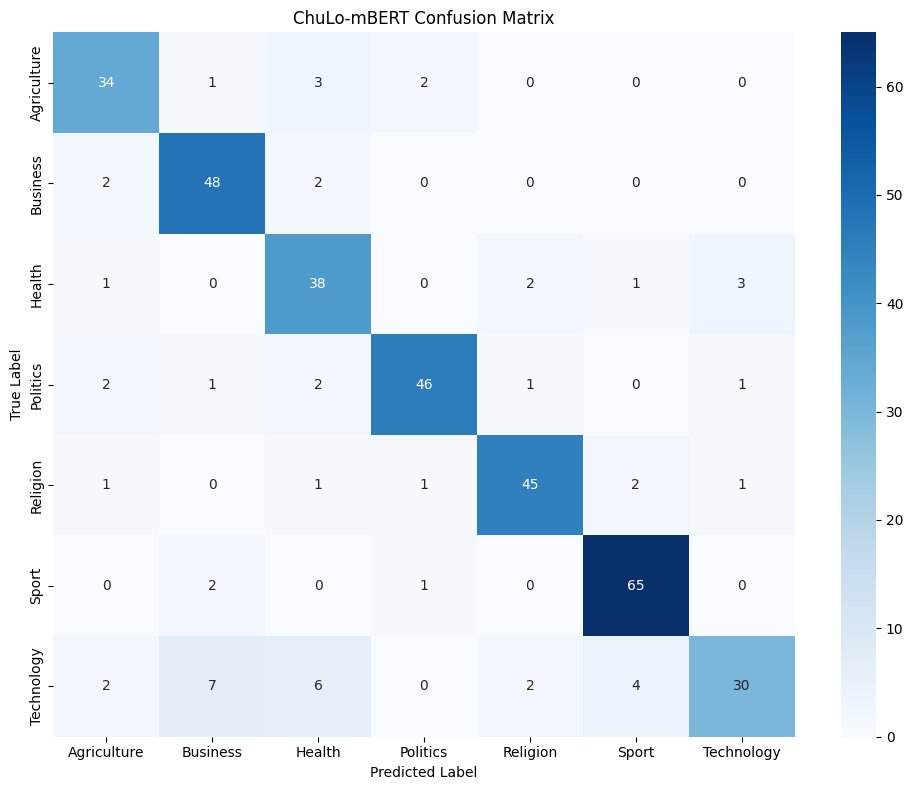

✅ Test evaluation completed successfully.


In [15]:
# ============================
# Cell 14 — Evaluate on Test Set (FINAL + SAFE)
# ============================

import torch
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------
# Full evaluation function (SAFE)
# ------------------------------------------------
def evaluate_full(model, loader):
    model.eval()
    preds, trues = [], []

    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in loader:
            if batch["input_ids"].size(0) == 0:
                continue  # safety

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=None
            )

            # SAFE logits extraction
            logits = outputs[1] if isinstance(outputs, tuple) else outputs

            pred = torch.argmax(logits, dim=-1)

            preds.extend(pred.cpu().tolist())
            trues.extend(labels.cpu().tolist())

    # Metrics
    acc = accuracy_score(trues, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        trues, preds, average="macro", zero_division=0
    )

    return {
        "preds": preds,
        "labels": trues,
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# ------------------------------------------------
# Evaluate on Test Set
# ------------------------------------------------
print("🧪 Evaluating on test set...")
test_results = evaluate_full(trained_model, test_loader)

print("\n==== TEST METRICS ====")
print({
    "accuracy": round(test_results["acc"], 4),
    "precision": round(test_results["precision"], 4),
    "recall": round(test_results["recall"], 4),
    "f1": round(test_results["f1"], 4),
})

# ------------------------------------------------
# Classification Report
# ------------------------------------------------
y_true = test_results["labels"]
y_pred = test_results["preds"]

target_names = [id2label[i] for i in sorted(id2label.keys())]

print("\n==== CLASSIFICATION REPORT ====\n")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=target_names,
        digits=4,
        zero_division=0
    )
)

# ------------------------------------------------
# Confusion Matrix
# ------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ChuLo‑mBERT Confusion Matrix")
plt.tight_layout()
plt.show()

print("✅ Test evaluation completed successfully.")


In [22]:
# ================================
# Cell 15 — Save & Upload ChuLo-mBERT to Hugging Face Hub (FINAL + SAFE)
# ================================

import os
import json
import torch
from huggingface_hub import notebook_login, HfApi, create_repo, upload_folder

# -----------------------------
# 1️⃣ Login to Hugging Face
# -----------------------------
# Run once in Colab (will prompt token)
notebook_login()

# -----------------------------
# 2️⃣ Repository details
# -----------------------------
REPO_ID = "Abelex/chulo-mbert-Tigrigna"   # 🔁 change to your HF username/repo
FINAL_SAVE_DIR = os.path.join(MODEL_SAVE_DIR, "hf_chulo_mbert")

os.makedirs(FINAL_SAVE_DIR, exist_ok=True)

# -----------------------------
# 3️⃣ Prepare model for saving
# -----------------------------
# Use trained_model from Cell 13
model_to_save = trained_model.module if hasattr(trained_model, "module") else trained_model
model_to_save.eval()
model_to_save.to("cpu")

# Save model weights (HF standard)
torch.save(
    model_to_save.state_dict(),
    os.path.join(FINAL_SAVE_DIR, "pytorch_model.bin")
)

# Save tokenizer
tokenizer.save_pretrained(FINAL_SAVE_DIR)

# -----------------------------
# 4️⃣ Save model configuration
# -----------------------------
config = {
    "model_type": "ChuLo-mBERT",
    "pretrained_backbone": PRETRAINED,
    "chunk_size": CHUNK_SIZE,
    "max_chunks": MAX_CHUNKS,
    "top_k_keys": TOP_K_KEYS,
    "key_alpha": KEY_ALPHA,
    "chunk_transformer_layers": CHUNK_TRANSFORMER_LAYERS,
    "chunk_dmodel": CHUNK_DMODEL,
    "num_labels": num_labels,
    "id2label": id2label,
    "label2id": label2id
}

with open(os.path.join(FINAL_SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

# -----------------------------
# 5️⃣ Create repo & upload
# -----------------------------
api = HfApi()

create_repo(
    repo_id=REPO_ID,
    exist_ok=True,
    repo_type="model"
)

upload_folder(
    folder_path=FINAL_SAVE_DIR,
    repo_id=REPO_ID,
    repo_type="model"
)

print(f"✅ ChuLo-mBERT successfully uploaded!")
print(f"🔗 https://huggingface.co/{REPO_ID}")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../hf_chulo_mbert/vocab.txt: 100%|##########| 1.55MB / 1.55MB            

  ...o_mbert/pytorch_model.bin:   0%|          | 1.11MB /  719MB            

✅ ChuLo-mBERT successfully uploaded!
🔗 https://huggingface.co/Abelex/chulo-mbert-Tigrigna


In [23]:
# ===============================
# Cell 16 — Safe ChuLo Inference (FINAL, ALIGNED)
# ===============================

import torch
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------
# 1️⃣ Chunking helper (IDENTICAL logic to Dataset)
# -------------------------------------------------
def chunk_token_ids(
    token_ids,
    tokenizer,
    chunk_size=CHUNK_SIZE,
    max_chunks=MAX_CHUNKS
):
    """
    Convert token ids into ChuLo chunks with CLS/SEP and padding.
    Fully aligned with training-time chunking.
    """
    cls_id = tokenizer.cls_token_id
    sep_id = tokenizer.sep_token_id
    pad_id = tokenizer.pad_token_id

    per_chunk = chunk_size - 2
    max_total = per_chunk * max_chunks

    # Hard truncation (same as training)
    token_ids = token_ids[:max_total]

    # Split into chunks
    chunks = []
    for i in range(0, len(token_ids), per_chunk):
        chunks.append(token_ids[i:i + per_chunk])

    # Pad missing chunks
    while len(chunks) < max_chunks:
        chunks.append([])

    # Add CLS / SEP and pad
    processed = []
    for ch in chunks[:max_chunks]:
        ch = [cls_id] + ch + [sep_id]
        if len(ch) < chunk_size:
            ch += [pad_id] * (chunk_size - len(ch))
        else:
            ch = ch[:chunk_size]
        processed.append(ch)

    return np.array(processed, dtype=np.int64)

# -------------------------------------------------
# 2️⃣ Prediction function (SAFE + CLEAN)
# -------------------------------------------------
def predict_text(
    model,
    tokenizer,
    text,
    id2label,
    top_k=TOP_K_KEYS
):
    """
    Predict label for a single Tigrigna document.
    Returns:
      - predicted label
      - full probability vector
      - top-k labels
      - top-k probabilities
    """
    model.eval()
    model.to(DEVICE)

    # Tokenize WITHOUT special tokens
    token_ids = tokenizer.encode(
        text,
        add_special_tokens=False,
        truncation=True
    )

    # Chunk document
    chunks = chunk_token_ids(
        token_ids=token_ids,
        tokenizer=tokenizer,
        chunk_size=CHUNK_SIZE,
        max_chunks=MAX_CHUNKS
    )

    # Build tensors
    input_ids = torch.tensor(chunks, dtype=torch.long).unsqueeze(0).to(DEVICE)
    attention_mask = (input_ids != tokenizer.pad_token_id).long().to(DEVICE)

    # Forward pass
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        if isinstance(logits, tuple):
            logits = logits[0]

        probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    # Top-1
    pred_id = int(np.argmax(probs))
    pred_label = id2label[pred_id]

    # Top-k
    k = min(top_k, len(probs))
    topk_idx = np.argsort(probs)[-k:][::-1]
    topk_labels = [id2label[i] for i in topk_idx]
    topk_probs = probs[topk_idx]

    return pred_label, probs, topk_labels, topk_probs

# -------------------------------------------------
# 3️⃣ Quick sanity test
# -------------------------------------------------
sample_text = train_df[TEXT_COLUMN].iloc[0]

pred_label, probs, topk_labels, topk_probs = predict_text(
    model=trained_model,
    tokenizer=tokenizer,
    text=sample_text,
    id2label=id2label
)

print("✅ Predicted label:", pred_label)
print("🔝 Top-k labels:", topk_labels)
print("📊 Top-k probs:", np.round(topk_probs, 4))


✅ Predicted label: Sport
🔝 Top-k labels: ['Sport', 'Agriculture', 'Technology', 'Religion']
📊 Top-k probs: [9.993e-01 3.000e-04 2.000e-04 1.000e-04]


In [24]:
import gradio as gr
import numpy as np

def chulo_keyphrase_view(text):
    if not text.strip():
        return "Please enter text.", None, None

    # 1️⃣ ChuLo inference
    pred_label, probs, topk_labels, topk_probs = predict_text(trained_model, tokenizer, text)

    # 2️⃣ Prepare probability table
    rows = [(id2label[i], float(probs[i])) for i in range(len(probs))]
    rows = sorted(rows, key=lambda x: x[1], reverse=True)
    rows = rows[:5]

    # 3️⃣ Visualize keyphrases
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    chunks = chunk_token_ids(token_ids, CHUNK_SIZE, MAX_CHUNKS, tokenizer.pad_token_id)

    html_chunks = []
    for idx, ch in enumerate(chunks, 1):
        tokens = tokenizer.convert_ids_to_tokens(ch)
        # Fake key-token example: top `TOP_K_KEYS` tokens highlighted
        key_indices = list(range(min(TOP_K_KEYS, len(tokens))))
        chunk_html = " ".join(
            f"<span style='color:red;'>{t}</span>" if i in key_indices else t
            for i, t in enumerate(tokens)
        )
        html_chunks.append(f"<b>Chunk {idx}:</b> {chunk_html}")

    html_view = "<br>".join(html_chunks)

    return f"Predicted Label: {pred_label}", rows, html_view


demo = gr.Interface(
    fn=chulo_keyphrase_view,
    inputs=gr.Textbox(
        lines=5,
        label="Enter Amharic News Text",
        placeholder="እባክዎ የአማርኛ ዜና ጽሑፍ ያስገቡ..."
    ),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Dataframe(
            headers=["Label", "Probability"],
            label="Top Class Probabilities"
        ),
        gr.HTML(label="ChuLo Keyphrase Chunks (red = key tokens)")
    ],
    title="ChuLo – Amharic Keyphrase Chunk Classifier",
    description=(
        "This model uses ChuLo key-token attention to handle long Amharic texts, highlighting key tokens in red."
    ),
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a139be9655328fbdbd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
